In [1]:
import os
import shutil
import rasterio
import numpy as np
from rasterio.mask import mask
import geopandas as gpd
from osgeo import gdal, ogr
import random

In [2]:
os.chdir('version_2')

In [3]:
os.getcwd()

'F:\\One_drive_Crimson_Shahid_Khan\\OneDrive - The University of Alabama\\Shahid Compter Data\\onedrive\\PhD Studies\\External Research\\drumair_land\\1_Data\\2_mosaiced_reclassified\\version_2'

In [4]:
input_folder = 'input'
output_folder = 'output'

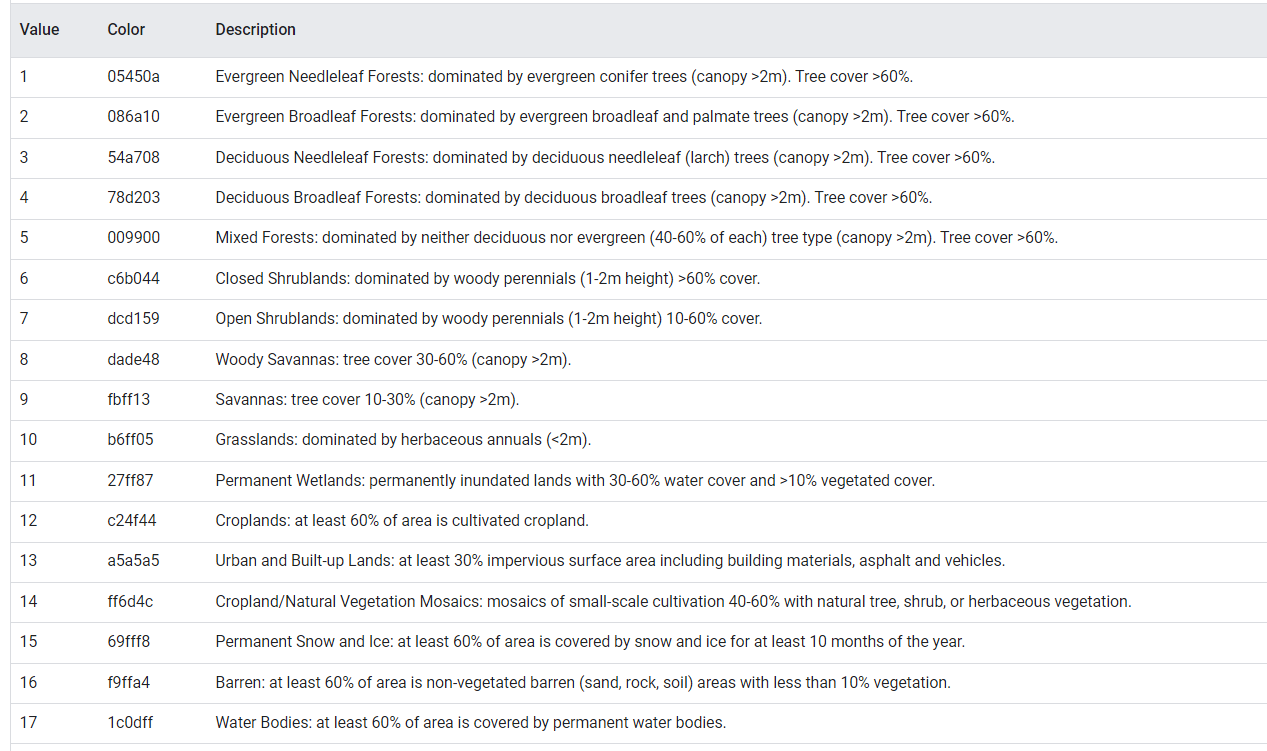

In [5]:
# We need three main classes as per the presentation we have. Grasslands, Forest and Croplands
#class 1-5 will go to Forests as 1
#class 10 will fo to grasslandas as 2
#class 14 will go to croplandas as 3


In [6]:
# Define the reclassification function
def reclassify(image_path):
    with rasterio.open(image_path) as src:
        # Read in the raster data
        data = src.read(1)
        # Reclassify the raster data based on input values
        reclassified_data = np.where(np.isin(data, [1, 2, 3, 4, 5]), 1, data)
        reclassified_data = np.where(np.isin(data, [10]), 2, reclassified_data)
        reclassified_data = np.where(np.isin(data, [12, 14]), 3, reclassified_data)
        reclassified_data = np.where(np.isin(data, [6, 7, 8, 9, 11, 13, 15, 16, 17]), 0, reclassified_data)

        # Write the reclassified data to a new GeoTIFF file
        profile = src.profile
        output_file_path = os.path.splitext(image_path)[0] + '_reclassified.tif'
        with rasterio.open(output_file_path, 'w', **profile) as dst:
            dst.write(reclassified_data, 1)

In [7]:
# Loop through all folders in the input folder
for folder_name in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, folder_name)
    if os.path.isdir(folder_path):
        # Find the image with the specified name in the current folder
        for filename in os.listdir(folder_path):
            if filename.endswith('LC_Type1.tif'):
                # Reclassify the image
                input_file_path = os.path.join(folder_path, filename)
                reclassify(input_file_path)

                # Move the reclassified image to the output folder
                output_folder_path = os.path.join(output_folder, folder_name)
                os.makedirs(output_folder_path, exist_ok=True)
                output_file_path = os.path.splitext(input_file_path)[0] + '_reclassified.tif'
                shutil.move(output_file_path, output_folder_path)


### Next we are clipping the data using admin boundaries

In [26]:
#clip function
def clip_tiff_with_shapefile(tiff_folder, shapefile_path, output_folder):   
    #create filder if not exists 
    os.makedirs(output_folder_path, exist_ok=True)
    # Open the shapefile
    shapefile = ogr.Open(shapefile_path)
    layer = shapefile.GetLayer()
    # Iterate over the TIFF files in the input folder
    for filename in os.listdir(tiff_folder):
        if filename.endswith(".tif"):
            tiff_path = os.path.join(tiff_folder, filename)
            output_path = os.path.join(output_folder, filename)
            # Open the TIFF file
            tiff_dataset = gdal.Open(tiff_path)
            # Perform the clipping operation
            clipped_dataset = gdal.Warp(output_path, tiff_dataset, cutlineDSName=shapefile_path, cropToCutline=True)           
            # Save the clipped image to the output folder
            clipped_dataset = None  # Close the dataset to flush the file to disk
    # Close the shapefile
    shapefile = None

In [27]:
# Specify the paths to the input folders and shapefile
tiff_folder = "output"
shapefile_path = "input_shp/kpk_boundaries.shp"
output_folder = "output_2_clipped"
folders = os.listdir(tiff_folder)
# Call the function to clip the TIFF images
for folder in folders:
    print("Processing: ", folder)
    current_folder = os.path.join(tiff_folder, folder)
    clip_tiff_with_shapefile(current_folder, shapefile_path, output_folder)

Processing:  2001
Processing:  2002
Processing:  2003
Processing:  2004
Processing:  2005
Processing:  2006
Processing:  2007
Processing:  2008
Processing:  2009
Processing:  2010
Processing:  2011
Processing:  2012
Processing:  2013
Processing:  2014
Processing:  2015
Processing:  2016
Processing:  2017
Processing:  2018
Processing:  2019
Processing:  2020
Processing:  2021


In [ ]:
#now we will generate a 1000 random points within KP boundaries for sampling the images

In [29]:
# Step 1: Read the shapefile
boundary_shapefile = "input_shp/kpk_boundaries.shp"
boundary = gpd.read_file(boundary_shapefile)

# Step 2: Generate random points
num_points = 1000
random_points = []
for _ in range(num_points):
    # Generate random coordinates within the bounding box of the boundary
    x = random.uniform(boundary.bounds.minx, boundary.bounds.maxx)
    y = random.uniform(boundary.bounds.miny, boundary.bounds.maxy)
    random_points.append(Point(x, y))

# Step 3: Filter points inside the boundary
points_inside_boundary = [point for point in random_points if boundary.contains(point).any()]

# Step 4: Create a new GeoDataFrame
gdf_points = gpd.GeoDataFrame(geometry=points_inside_boundary, crs=boundary.crs)

# Step 5: Save the GeoDataFrame to a new shapefile
output_shapefile = "input_shp/points.shp"
gdf_points.to_file(output_shapefile)


In [ ]:
# Iterate over the TIFF images and extract values for each point
for tiff_path in tiff_paths:
    with rasterio.open(tiff_path) as src:
        # Extract pixel values for all points
        values = [x[0] for x in src.sample(gdf.geometry.apply(lambda geom: (geom.x, geom.y)))]
        
        # Add the extracted values to the GeoDataFrame
        gdf[tiff_path] = values

# Save the updated GeoDataFrame as a shapefile
gdf.to_file(shapefile_path)
